In [1]:
import numpy as np
from sklearn.utils import shuffle
import matplotlib.pyplot as plt

from util import get_normalized_data, error_rate, cost, y2indicator
from mlp import forward, derivative_w2, derivative_w1, derivative_b2, derivative_b1

%matplotlib inline

In [2]:
max_iter = 20 # make it 30 for sigmoid
print_period = 10

X, Y = get_normalized_data()
lr = 0.00004
reg = 0.01

Xtrain = X[:-1000,]
Ytrain = Y[:-1000]
Xtest = X[-1000:,]
Ytest = Y[-1000:]
Ytrain_ind = y2indicator(Ytrain)
Ytest_ind = y2indicator(Ytest)

N, D = Xtrain.shape
batch_sz = 500
n_batches = N//batch_sz



Reading in and transforming data...


/Users/admin/Code/udemy_courses/4_practical_deep_learning_tensorflow/util.py:104: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  ind[i, y[i]] = 1


In [7]:
# 1. Constant Learning Rate
M = 300
K = 10
W1 = np.random.randn(D, M) / 28
b1 = np.zeros(M)
W2 = np.random.randn(M, K) / np.sqrt(M)
b2 = np.zeros(K)

# cost = -16
LL_batch = []
CR_batch = []
for i in range(max_iter):
    for j in range(n_batches):
        Xbatch = Xtrain[j*batch_sz:(j*batch_sz + batch_sz),]
        Ybatch = Ytrain_ind[j*batch_sz:(j*batch_sz + batch_sz),]
        pYbatch, Z = forward(Xbatch, W1, b1, W2, b2)
        
        # updates. No momentum, just normal gradient descent
        W2 -= lr*(derivative_w2(Z, Ybatch, pYbatch) + reg*W2)
        b2 -= lr*(derivative_b2(Ybatch, pYbatch) + reg*b2)
        W1 -= lr*(derivative_w1(Xbatch, Z, Ybatch, pYbatch, W2) + reg*W1)
        b1 -= lr*(derivative_b1(Z, Ybatch, pYbatch, W2) + reg*b1)
        
        if j % print_period == 0:
            # calculate jsut for LL
            pY, _ = forward(Xtest, W1, b1, W2, b2)
            ll = cost(pY, Ytest_ind)
            LL_batch.append(ll)
            print("Cost at iteration i=%d, j=%d: %.6f" % (i, j, ll))
            
            err = error_rate(pY, Ytest)
            CR_batch.append(err)
            print("Error rate:", err)
            
pY, _ = forward(Xtest, W1, b1, W2, b2)
print("Final error rate:", error_rate(pY, Ytest))

Cost at iteration i=0, j=0: 2293.732392
Error rate: 0.859
Cost at iteration i=0, j=10: 2156.152602
Error rate: 0.681
Cost at iteration i=0, j=20: 2065.192446
Error rate: 0.568
Cost at iteration i=0, j=30: 1980.303559
Error rate: 0.494
Cost at iteration i=0, j=40: 1901.142277
Error rate: 0.435
Cost at iteration i=0, j=50: 1823.227168
Error rate: 0.375
Cost at iteration i=0, j=60: 1753.362407
Error rate: 0.357
Cost at iteration i=0, j=70: 1685.652059
Error rate: 0.311
Cost at iteration i=0, j=80: 1620.786237
Error rate: 0.307
Cost at iteration i=1, j=0: 1608.664576
Error rate: 0.292
Cost at iteration i=1, j=10: 1549.875915
Error rate: 0.277
Cost at iteration i=1, j=20: 1493.221296
Error rate: 0.268
Cost at iteration i=1, j=30: 1439.902375
Error rate: 0.253
Cost at iteration i=1, j=40: 1391.463362
Error rate: 0.248
Cost at iteration i=1, j=50: 1343.428390
Error rate: 0.242
Cost at iteration i=1, j=60: 1300.849577
Error rate: 0.232
Cost at iteration i=1, j=70: 1259.431119
Error rate: 0.225

In [8]:
# 2. RMSprop
W1 = np.random.randn(D, M) / 28
b1 = np.zeros(M)
W2 = np.random.randn(M, K) / np.sqrt(M)
b2 = np.zeros(K)
LL_rms = []
CR_rms = []
lr0 = 0.001 # If you set this too high you'll get NaN!
cache_W2 = 0
cache_b2 = 0
cache_W1 = 0
cache_b1 = 0
decay_rate = 0.999
eps = 0.000001

for i in range(max_iter):
    for j in range(n_batches):
        Xbatch = Xtrain[j*batch_sz:(j*batch_sz + batch_sz),]
        Ybatch = Ytrain_ind[j*batch_sz:(j*batch_sz + batch_sz),]
        pYbatch, Z = forward(Xbatch, W1, b1, W2, b2)
        
        # updates. No momentum, adaptive learning rate
        gW2 = derivative_w2(Z, Ybatch, pYbatch) + reg*W2
        cache_W2 = decay_rate*cache_W2 + (1 - decay_rate)*gW2*gW2
        W2 -= lr0 * gW2 / (np.sqrt(cache_W2) + eps)
        
        gb2 = derivative_b2(Ybatch, pYbatch) + reg*b2
        cache_b2 = decay_rate*cache_b2 + (1-decay_rate)*gb2*gb2
        b2 -= lr0 * gb2 / (np.sqrt(cache_b2) + eps)
        
        gW1 = derivative_w1(Xbatch, Z, Ybatch, pYbatch, W2) + reg*W1
        cache_W1 = decay_rate*cache_W1 + (1 - decay_rate)*gW1*gW1
        W1 -= lr0 * gW1 / (np.sqrt(cache_W1) + eps)
        
        gb1 = derivative_b1(Z, Ybatch, pYbatch, W2) + reg*b1
        cache_b1 = decay_rate*cache_b1 + (1 - decay_rate)*gb1*gb1
        b1 -= lr0 * gb1 / (np.sqrt(cache_b1) + eps)
        
        if j % print_period == 0:
            # calculate jsut for LL
            pY, _ = forward(Xtest, W1, b1, W2, b2)
            ll = cost(pY, Ytest_ind)
            LL_rms.append(ll)
            print("Cost at iteration i=%d, j=%d: %.6f" % (i, j, ll))
            
            err = error_rate(pY, Ytest)
            CR_rms.append(err)
            print("Error rate:", err)
            
pY, _ = forward(Xtest, W1, b1, W2, b2)
print("Final error rate:", error_rate(pY, Ytest))

Cost at iteration i=0, j=0: 3473.790945
Error rate: 0.466
Cost at iteration i=0, j=10: 462.438340
Error rate: 0.136
Cost at iteration i=0, j=20: 335.629905
Error rate: 0.097
Cost at iteration i=0, j=30: 308.162341
Error rate: 0.096
Cost at iteration i=0, j=40: 276.235217
Error rate: 0.085
Cost at iteration i=0, j=50: 259.607105
Error rate: 0.074
Cost at iteration i=0, j=60: 251.417493
Error rate: 0.069
Cost at iteration i=0, j=70: 249.531259
Error rate: 0.071
Cost at iteration i=0, j=80: 233.269143
Error rate: 0.066
Cost at iteration i=1, j=0: 237.956964
Error rate: 0.067
Cost at iteration i=1, j=10: 224.266955
Error rate: 0.062
Cost at iteration i=1, j=20: 215.436803
Error rate: 0.063
Cost at iteration i=1, j=30: 218.631332
Error rate: 0.069
Cost at iteration i=1, j=40: 203.933667
Error rate: 0.063
Cost at iteration i=1, j=50: 199.716306
Error rate: 0.059
Cost at iteration i=1, j=60: 199.545427
Error rate: 0.06
Cost at iteration i=1, j=70: 200.220093
Error rate: 0.06
Cost at iteration

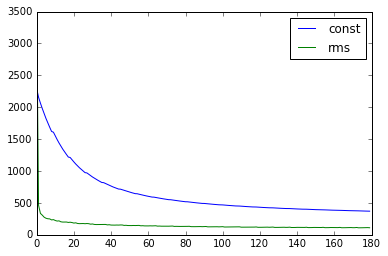

In [9]:
plt.plot(LL_batch, label='const')
plt.plot(LL_rms, label='rms')
plt.legend()
plt.show() # rmsprop learned faster and gave us a higher final classification rate!